In [ ]:
# outcome probability model for fastballs

In [1]:
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import mysql.connector
import pybaseball
from sklearn.metrics import accuracy_score, confusion_matrix

In [15]:
# load in 2022 mlb season data

df = pd.read_csv(r'C:\Users\adam.bloebaum\.vscode\driveline\2022_MLB_Season.csv')

# ensure df is sequential

df.sort_values(by=['game_pk', 'inning', 'at_bat_number', 'pitch_number'], inplace=True)

# convert batter handedness columns to binary

stand_encoder = LabelEncoder()

df['stand'] = stand_encoder.fit_transform(df['stand'])

# generate unique id column

df['pitch_id'] = df['game_pk'].astype(str) + "_" + \
                            df['batter'].astype(str) + "_" + \
                            df['pitcher'].astype(str) + "_" + \
                            df['pitch_number'].astype(str) + "_" + \
                            df['at_bat_number'].astype(str) + "_" + \
                            df['inning'].astype(str)

# select only fastballs

df = df[df['pitch_type'].isin(['FF', 'SI', 'FC', 'FA', 'FT'])]

# normalize LHP values to RHP standards

df.loc[df['p_throws'] == 'L', 'pfx_x'] = df['pfx_x'] * -1
df.loc[df['p_throws'] == 'L', 'release_pos_x'] = df['release_pos_x'] * -1
df['spin_axis'] = 360 - df['spin_axis']

# total movement column

df['pfx_total'] = abs(df['pfx_x']) + abs(df['pfx_z'])

# movement ratio column

df['pfx_x_ratio'] = abs(df['pfx_x']) / df['pfx_total']
df['pfx_z_ratio'] = abs(df['pfx_z']) / df['pfx_total']

In [ ]:
# load in 2023 mlb season data

df_2023 = pd.read_csv(r"C:\Users\adam.bloebaum\.vscode\driveline\2023_MLB_Season.csv")

# ensure df is sequential

df_2023.sort_values(by=['game_pk', 'inning', 'at_bat_number', 'pitch_number'], inplace=True)

# convert batter handedness columns to binary

df_2023['stand'] = stand_encoder.fit_transform(df_2023['stand'])

# generate unique id column

df_2023['pitch_id'] = df_2023['game_pk'].astype(str) + "_" + \
                            df_2023['batter'].astype(str) + "_" + \
                            df_2023['pitcher'].astype(str) + "_" + \
                            df_2023['pitch_number'].astype(str) + "_" + \
                            df_2023['at_bat_number'].astype(str) + "_" + \
                            df_2023['inning'].astype(str)

# select only fastballs

df_2023 = df_2023[df_2023['pitch_type'].isin(['FF', 'SI', 'FC', 'FA', 'FT'])]

# normalize LHP values to RHP standards

df_2023.loc[df_2023['p_throws'] == 'L', 'pfx_x'] = df_2023['pfx_x'] * -1
df_2023.loc[df_2023['p_throws'] == 'L', 'release_pos_x'] = df_2023['release_pos_x'] * -1
df_2023['spin_axis'] = 360 - df['spin_axis']

# total movement column

df_2023['pfx_total'] = abs(df_2023['pfx_x']) + abs(df_2023['pfx_z'])

# movement ratio column

df_2023['pfx_x_ratio'] = abs(df_2023['pfx_x']) / df_2023['pfx_total']
df_2023['pfx_z_ratio'] = abs(df_2023['pfx_z']) / df_2023['pfx_total']

In [19]:
# create outcome column using events and description columns

description_mapping = {
    'ball': 'ball',
    'hit_by_pitch': 'ball',
    'blocked_ball': 'ball',
    'swinging_strike': 'whiff',
    'missed_bunt': 'whiff',
    'swinging_strike_blocked': 'whiff',
    'foul_bunt': 'foul',
    'foul': 'foul',
    'foul_tip': 'foul',
    'bunt_foul_tip': 'foul',
    'called_strike': 'called_strike'
}

events_mapping = {
    'fielders_choice': 'out',
    'field_out': 'out',
    'force_out': 'out',
    'field_error': 'out',
    'grounded_into_double_play': 'out',
    'sac_fly': 'out',
    'fielders_choice_out': 'out',
    'sac_bunt': 'out',
    'double_play': 'out',
    'sac_fly_double_play': 'out',
    'other_out': 'out',
    'single': 'single',
    'double': 'double',
    'triple': 'triple',
    'home_run': 'home_run'
}

outcome_encoder = LabelEncoder()

# 2022 mapping

df['outcome'] = np.where(
    df['description'] != 'hit_into_play',
    df['description'].map(description_mapping),
    df['events'].map(events_mapping)
)

df.dropna(subset=['outcome'], inplace=True)

df['outcome'] = outcome_encoder.fit_transform(df['outcome'])

# 2023 mapping

df_2023['outcome'] = np.where(
    df_2023['description'] != 'hit_into_play',
    df_2023['description'].map(description_mapping),
    df_2023['events'].map(events_mapping)
)

df_2023.dropna(subset=['outcome'], inplace=True)

df_2023['outcome'] = outcome_encoder.fit_transform(df['outcome'])


In [20]:
# feature selection and data splitting

features = ['release_speed', 'release_pos_x', 'release_pos_y', 'release_pos_z', 'release_extension', 'release_spin_rate', 'spin_axis', 'pfx_x', 'pfx_z', 'pfx_total', 'pfx_x_ratio', 'pfx_z_ratio']

# copy and keep only features

df_2023_features = df_2023[features]

# create features and targets

X = df[features]
y = df['outcome']

# train valid test split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [21]:
# set up model
# change num_class once we have other pitch features

model = xgb.XGBClassifier(objective='multi:softmax', num_class=9, eval_metric='mlogloss', use_label_encoder=False)

# train model

model.fit(X_train, y_train)

c:\Users\adam.bloebaum\AppData\Local\miniconda3\envs\driveline\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_class=9, num_parallel_tree=None, objective='multi:softmax', ...)

In [22]:
# make predictions

y_pred = model.predict(X_test)

# evaluate the model

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')

Accuracy: 0.33710109622411694
Confusion Matrix:
[[13588   123     0   217     0    15     2     0    25]
 [ 7158    92     0    93     0     6     0     0     7]
 [  468     5     0     6     0     1     0     0     3]
 [ 8467    67     0   141     0     8     1     0    14]
 [  294     5     0     3     0     0     0     0     1]
 [ 4922    41     0    74     0     6     0     0     6]
 [ 1545    13     0    18     0     1     0     0     2]
 [   40     1     0     0     0     0     0     0     0]
 [ 3455    26     0    72     0     7     0     0    11]]


<Figure size 1000x2000 with 0 Axes>

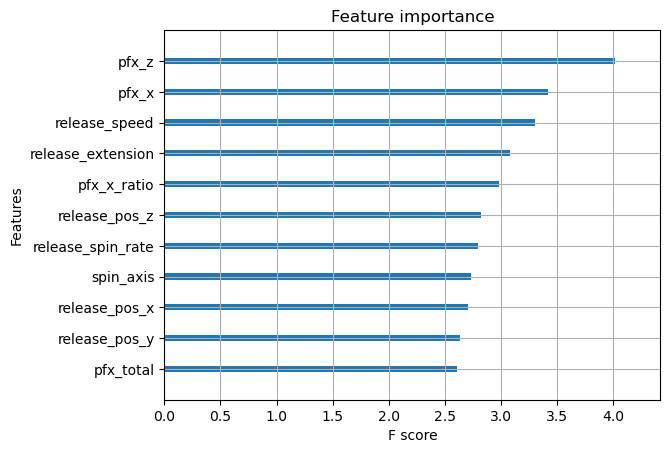

In [23]:
# plot feature importances

plt.figure(figsize=(10, 20))
xgb.plot_importance(model, max_num_features=None, importance_type='gain', show_values=False)
plt.savefig('feature_importance.png')
plt.show()

In [24]:
# get feature importance dictionary

importance = model.get_booster().get_score(importance_type='gain')

# sort features by importance

sorted_importance = sorted(importance.items(), key=lambda item: item[1], reverse=True)

# loop to print

for feature, score in sorted_importance:
    print(f'{feature}: {score}')

pfx_z: 4.020059108734131
pfx_x: 3.4203217029571533
release_speed: 3.3043899536132812
release_extension: 3.0818865299224854
pfx_x_ratio: 2.9863905906677246
release_pos_z: 2.8185782432556152
release_spin_rate: 2.797513484954834
spin_axis: 2.7378172874450684
release_pos_x: 2.7062132358551025
release_pos_y: 2.6310484409332275
pfx_total: 2.607329845428467


In [32]:
print(df.shape)

(410494, 98)


In [36]:
outcome_probabilities = model.predict_proba(df_2023_features)

# not entirely sure how to apply these back onto the 2023 df

In [37]:
print(outcome_probabilities[0])

[3.61592352e-01 2.15752512e-01 1.36997495e-02 1.91809356e-01
 1.04496591e-02 1.20245792e-01 3.21229324e-02 3.13361961e-04
 5.40142134e-02]


In [38]:
print(model.classes_)

[0 1 2 3 4 5 6 7 8]


In [ ]:
for i, class_label in enumerate(model.classes_):
    df_2023[f'prob_{class_label}'] = outcome_probabilities[:, i]